<a href="https://colab.research.google.com/github/alifabdullah/DataScience/blob/main/BUSI_project_VIT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: train_acc=0.5160 val_acc=0.5577
Epoch 2: train_acc=0.6058 val_acc=0.8077
Epoch 3: train_acc=0.7051 val_acc=0.7564
Epoch 4: train_acc=0.8253 val_acc=0.7500
Epoch 5: train_acc=0.8606 val_acc=0.7885
Epoch 6: train_acc=0.9215 val_acc=0.8590
Epoch 7: train_acc=0.9631 val_acc=0.7051
Epoch 8: train_acc=0.9343 val_acc=0.8333
Epoch 9: train_acc=0.9776 val_acc=0.8526
Epoch 10: train_acc=0.9760 val_acc=0.8141


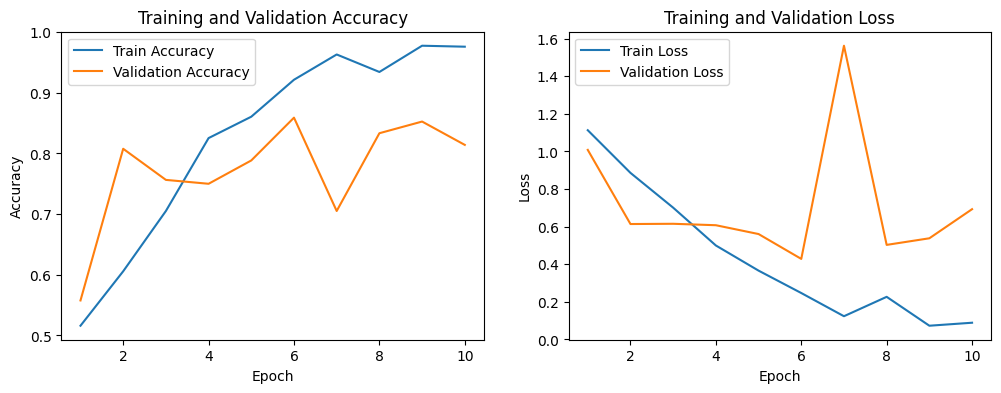

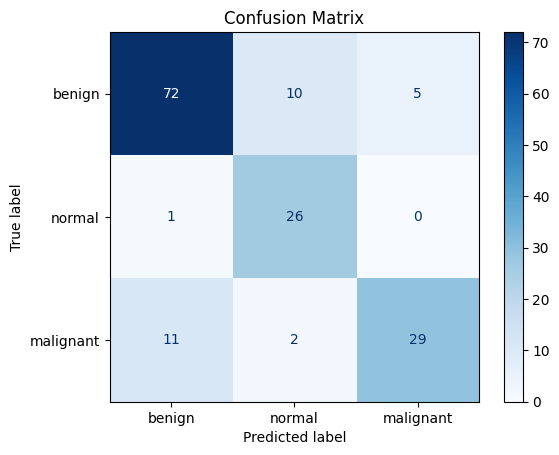

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import timm
from sklearn.model_selection import train_test_split
import pandas as pd
import kagglehub

class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

def train(model, loader, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, device):
    model.eval()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def main():
    # Download dataset from Kaggle
    path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
    print("Path to dataset files:", path)

    data_dir = os.path.join(path, "Dataset_BUSI_with_GT")

    # Build pseudo labels if no CSV available
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    filepaths, labels = [], []
    for i, c in enumerate(classes):
        class_dir = os.path.join(data_dir, c)
        for f in os.listdir(class_dir):
            if f.endswith('.png') and 'mask' not in f:
                filepaths.append(os.path.join(class_dir, f))
                labels.append(i)

    train_imgs, val_imgs, train_labels, val_labels = train_test_split(filepaths, labels, test_size=0.2, stratify=labels)
    train_ds = UltrasoundDataset(train_imgs, train_labels)
    val_ds = UltrasoundDataset(val_imgs, val_labels)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = timm.create_model('vit_base_patch16_224', pretrained=True, in_chans=1, num_classes=len(classes))
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, train_loader, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, device)
        print(f'Epoch {epoch+1}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    torch.save(model.state_dict(), 'vit_breast_ultrasound.pth')

    # Plot accuracy and loss curves
    epochs = range(1, 11)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Generate Confusion Matrix
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == '__main__':
    main()